# Import libraries

In [1]:
from models.UMNN import UMNNMAFFlow
import torch
import lib.toy_data as toy_data
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import os
import lib.utils as utils
import lib.visualize_flow as vf
from random import sample
import argparse

%matplotlib inline

# Define plotting function

In [2]:
def summary_plots(x, x_test, model):
    green = '#e15647'
    black = '#2d5468'
    white_bg = '#ececec'
    
    plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    vf.plt_flow(model.compute_ll, ax)
    plt.title("Target density estimate")
    
    plt.figure()
    z = torch.distributions.Normal(0., 1.).sample(x_test.shape)
    plt.figure(figsize=(7, 7))
    plt.xlim(-4.5, 4.5)
    plt.ylim(-4.5, 4.5)

    plt.xlabel("$z_1$", fontsize=20)
    plt.ylabel("$z_2$", fontsize=20)
    plt.title("Source density samples")
    plt.scatter(z[:, 0], z[:, 1], alpha=.2, color=green)
    x_min = z.min(0)[0] - .5
    x_max = z.max(0)[0] + .5
    ticks = [1, 1]

    plt.xticks([-4, 0, 4])
    plt.yticks([-4, 0, 4])
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_facecolor(white_bg)

    ax.tick_params(axis='x', colors=black)
    ax.tick_params(axis='y', colors=black)
    ax.spines['bottom'].set_color(black)
    ax.spines['left'].set_color(black)
    plt.tight_layout()

    z_pred = model.forward(x_test)
    z_pred = z_pred.detach().cpu().numpy()
    plt.figure()
    plt.scatter(z_pred[:, 0], z_pred[:, 1], alpha=.2)
    plt.xticks(np.arange(int(x_min[0]), int(x_max[0]), ticks[0]), np.arange(int(x_min[0]), int(x_max[0]), ticks[0]))
    plt.yticks(np.arange(int(x_min[1]), int(x_max[1]), ticks[1]), np.arange(int(x_min[1]), int(x_max[1]), ticks[1]))
    plt.title("Source density generated samples (pushforward of target samples)")    
    plt.tight_layout()
    
    z = torch.distributions.Normal(0., 1.).sample((1000, 2))
    x_pred = model.invert(z, 5, "ParallelSimpler")
    plt.figure()
    x_pred = x_pred.detach().cpu().numpy()
    plt.scatter(x_pred[:, 0], x_pred[:, 1], alpha=.2)
    x_min = x.min(0)[0] - .5
    x_max = x.max(0)[0] + .5
    ticks = [1, 1]
    plt.xticks(np.arange(int(x_min[0]), int(x_max[0]), ticks[0]), np.arange(int(x_min[0]), int(x_max[0]), ticks[0]))
    plt.yticks(np.arange(int(x_min[1]), int(x_max[1]), ticks[1]), np.arange(int(x_min[1]), int(x_max[1]), ticks[1]))
    plt.title("Target density generated samples (pullback of source samples)")
    plt.tight_layout()
    
    plt.figure(figsize=(7, 7))
    plt.xlim(-4.5, 4.5)
    plt.ylim(-4.5, 4.5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xticks([-4, 0, 4])
    plt.yticks([-4, 0, 4])
    plt.xlabel("$x_1$", fontsize=20)
    plt.ylabel("$x_2$", fontsize=20)
    plt.title("Target density training samples")
    plt.scatter(x[:, 0], x[:, 1], alpha=.2, color='#e15647')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_facecolor(white_bg)

    ax.tick_params(axis='x', colors=black)
    ax.tick_params(axis='y', colors=black)
    ax.spines['bottom'].set_color(black)
    ax.spines['left'].set_color(black)
    plt.tight_layout()

# Define model training function

In [3]:
def train_toy(toy, load=True, nb_steps=20, nb_flow=1, folder="",nb_samps=[1000],ns=1,steps=500,batch_size=100,
              plot=False, check=False, nb_test = 1000, width=10):
    device = "cpu"
    
    model = UMNNMAFFlow(nb_flow=nb_flow, nb_in=2, hidden_derivative=[width, width, width, width], 
                        hidden_embedding=[width, width, width, width],
                        embedding_s=10, nb_steps=nb_steps, device=device).to(device)
    opt = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)

    if load:
        model.load_state_dict(torch.load(folder + toy+'/model.pt'))
        model.train()
        opt.load_state_dict(torch.load(folder + toy+'/ADAM.pt'))

    x_test = torch.tensor(toy_data.inf_train_gen(toy, batch_size=nb_test)).to(device)
    
    iters = steps
    checks = steps
    
    ll_tests = np.zeros(ns)
    
    if check:
        ll_trains = np.zeros([ns,checks])
    else:
        ll_trains = False
    
    count = 0
    for nb_samp in nb_samps:
        x = toy_data.inf_train_gen(toy, batch_size=nb_samp)
        x_train = torch.tensor(x).to(device)
        steps = int(iters/(nb_samp/batch_size))
        
        steps = 0
        while steps < iters:
            x_train = x_train[sample(range(nb_samp),nb_samp),]
            k = 0
            while k < nb_samp//batch_size:
                cur_x = x_train[(k*batch_size):((k+1)*batch_size-1),]
            
                if plot: 
                    ll_tot = 0
                    
                ll, z = model.compute_ll(cur_x)
                loss = -ll.mean()
                if plot: 
                    ll_tot += loss.detach()/(nb_samp/batch_size)

                opt.zero_grad()
                loss.backward()
                opt.step()
  
                if check:
                    ll_train, _ = model.compute_ll(x_train)
                    ll_train = (-ll_train.mean()).item()
                    ll_trains[count,steps] = ll_train
                
                steps += 1
                k += 1
                
                if steps >= iters:
                    k = nb_samp//batch_size

        ll_test, _ = model.compute_ll(x_test)
        ll_test = -ll_test.mean()
        if plot:
            summary_plots(x_train, x_test, model)
        ll_test = ll_test.item()
        ll_tests[count] = ll_test
        
        count += 1
    return(ll_trains,ll_tests)

# Fit the model

In [4]:
datasets = ["joint_gaussian1"]  # see lib/toy_data.py for all toy dataset options

parser = argparse.ArgumentParser(description='')
parser.add_argument("-dataset", default=None, choices=datasets, help="Which toy problem ?")
parser.add_argument("-load", default=False, action="store_true", help="Load a model ?")
parser.add_argument("-folder", default="", help="Folder")
args = parser.parse_args()

nb_samps = np.round(np.array([10**3]),-1) # number of training samples (round to nearest multiple of 10)
ns = np.size(nb_samps) # length of vector of training sample sizes
batch_size = 100 # batch size for minibatch SGD
steps = 5000 # number of gradient steps
nb_test = 1000 # number of test samples
width = 50 # embedding network layer width
plot = True

<ipython-input-3-58dccfd92c8e>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(toy_data.inf_train_gen(toy, batch_size=nb_test)).to(device)
<ipython-input-3-58dccfd92c8e>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x).to(device)


0


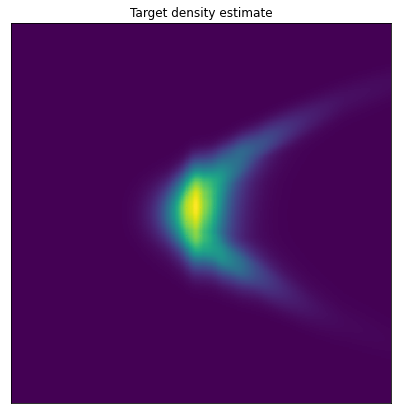

<Figure size 432x288 with 0 Axes>

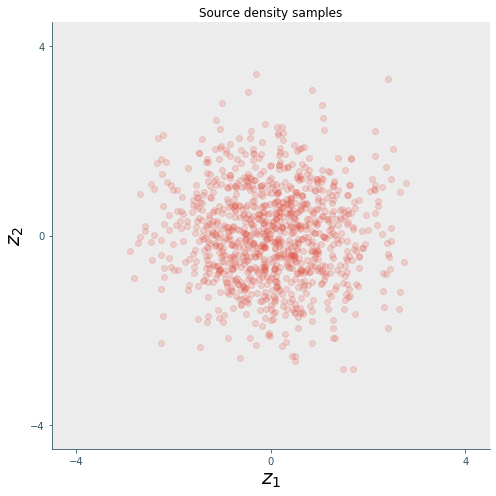

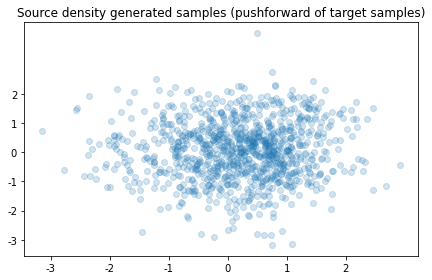

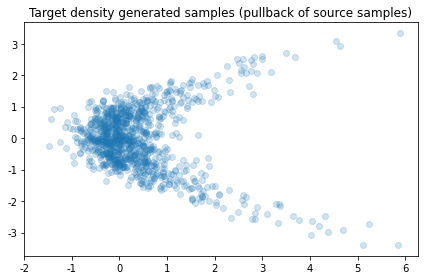

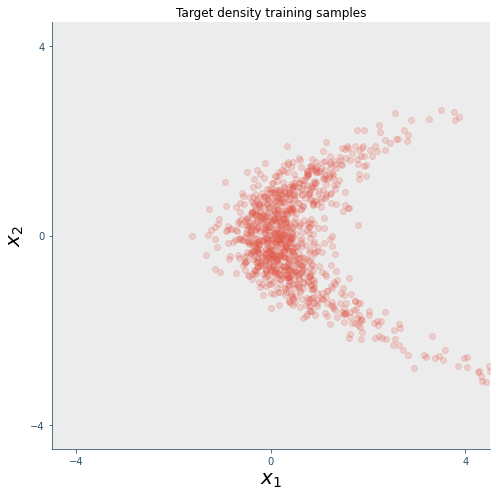

In [5]:
for toy in datasets:
    if not(os.path.isdir(args.folder + toy)):
        os.makedirs(args.folder + toy)
    ll_trains, ll_tests = train_toy(toy=toy, load=args.load, folder=args.folder,
                                    ns=ns, nb_samps=nb_samps,steps=steps, 
                                    batch_size=batch_size, nb_test=nb_test,
                                    check = False, plot=plot, width=width)